In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn

# VIT Paper
Well Try to implement the vision transformer paper by going step by step

Below is the representation of our dataset including image and also its class labels with names




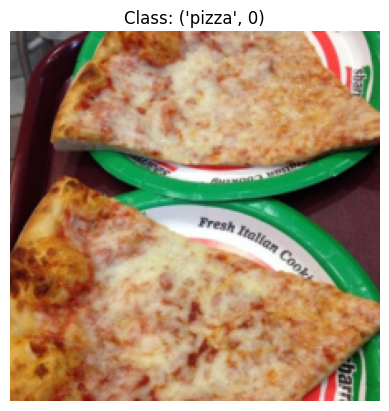

In [39]:
img_transforms = transforms.Compose([transforms.Resize((224,224))])
train_data = datasets.ImageFolder("../data/train", transform=img_transforms)
image, label = train_data[0]
print("Below is the representation of our dataset including image and also its class labels with names")
print("\n")
plt.imshow(image)
plt.title(f"Class: {train_data.classes[label], label}")
plt.axis("off")
plt.show()
print("\n")

**Input to a vision transformer**

```python
x_input = [class_token, image_patch_1, image_patch_2,.....,image_patch_n] + 
[class_token_pos, image_patch_1_pos,........,image_patch_n_pos]
```

In [40]:
to_tensor = transforms.ToTensor()
img = to_tensor(image)

In [47]:
print("Shape of 1 channel of the image :", img[0].shape, " and if we have a patch size of 16, 16.")

Shape of 1 channel of the image : torch.Size([224, 224])  and if we have a patch size of 16, 16.


In [55]:
h = 224
w = 224
p = 16
c = 3
number_of_patches = int((h*w) / (p**2))
print(number_of_patches)

196


In [56]:
#Embedding Layer input shape
input_shape = (h, w, c)

#Embedding layer output shape
output_shape = (number_of_patches, p**2 * c)

print(input_shape, output_shape)

(224, 224, 3) (196, 768)


In [58]:
patched_img = img.reshape(number_of_patches, -1)
print(patched_img.shape)

torch.Size([196, 768])


In [61]:
def show_image_patches(img, patch_size=16):
    """
    Display an image split into patches.
    
    Args:
        img (torch.Tensor): Image tensor of shape (C, H, W), values in [0,1].
        patch_size (int): Size of square patches.
    """
    C, H, W = img.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dims must be divisible by patch_size"

    # Number of patches
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Create figure
    fig, axes = plt.subplots(num_patches_h, num_patches_w, figsize=(8, 8))
    axes = axes.flatten()

    # Extract and plot patches
    patch_idx = 0
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = img[:, i:i+patch_size, j:j+patch_size]
            patch = patch.permute(1, 2, 0).numpy()  # (H, W, C)

            axes[patch_idx].imshow(patch)
            axes[patch_idx].axis("off")
            patch_idx += 1

    plt.tight_layout()
    plt.show()

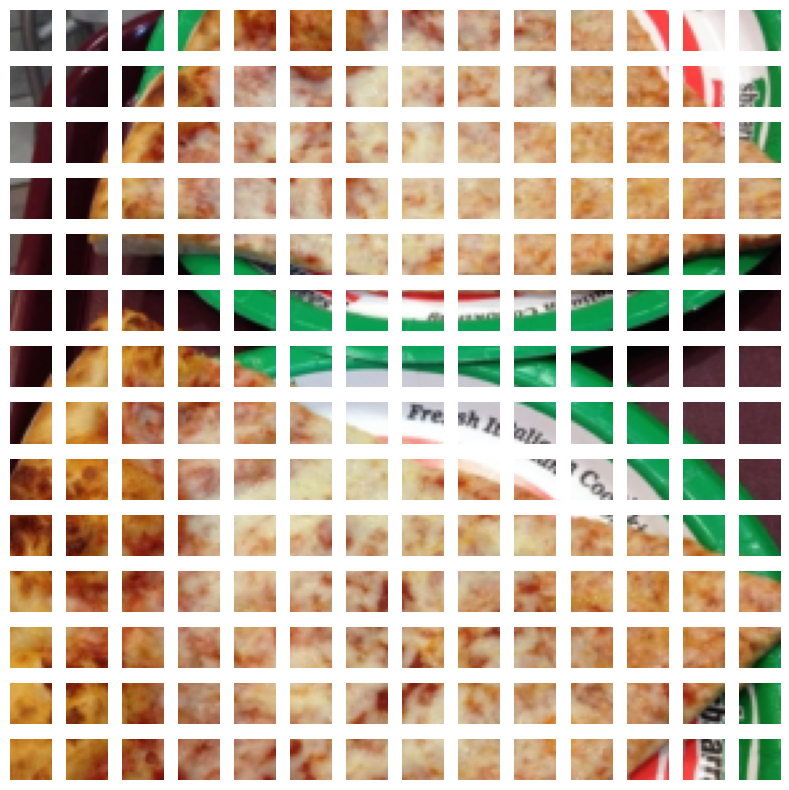

In [63]:
show_image_patches(img)

In [66]:
input_img = img.unsqueeze(0)
print(input_img.shape)

torch.Size([1, 3, 224, 224])


In [71]:
conv = torch.nn.Conv2d(in_channels=3, out_channels=768, stride=16, kernel_size=16)
flat = torch.nn.Flatten(start_dim=-2, end_dim=-1)

In [72]:
conv_output = conv(input_img)
flattened = flat(conv_output)

In [74]:
flattened = flattened.permute(0,2,1)
print(flattened.shape)

torch.Size([1, 196, 768])


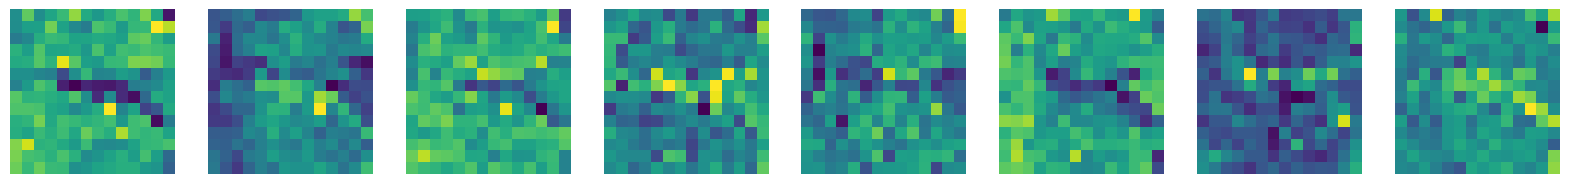

In [78]:
# Plot first 8 feature maps
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    axes[i].imshow(conv_output[0][100+i].detach().numpy(), cmap="viridis")
    axes[i].axis("off")
plt.show()

In [80]:
batch_size, embedding_dim = flattened.shape[0], flattened.shape[-1]
batch_size, embedding_dim

(1, 768)

In [81]:
classtoken = torch.nn.Parameter(torch.ones(batch_size, 1, embedding_dim))

In [85]:
classtoken.shape, flattened.shape

(torch.Size([1, 1, 768]), torch.Size([1, 196, 768]))

In [86]:
embed_class = torch.cat((classtoken, flattened), dim=1)

In [87]:
embed_class.shape

torch.Size([1, 197, 768])

In [89]:
embed_class[:,0,:10]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SliceBackward0>)

In [3]:
attention = nn.MultiheadAttention(embed_dim=50, num_heads=1, dropout=0, batch_first=True)
rand_inp = torch.randn(1, 10, 50) #of shape (batch_size, num_patches, embedding_dim)

In [5]:
x = attention(key=rand_inp, query=rand_inp, value=rand_inp, need_weights=False)

In [8]:
len(x)

2

## Transformer Layer from pytorch

well use the transformer layer from pytorch to do what we using attention and layernorm and mlp

In [11]:
transformer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation="gelu", batch_first=True, norm_first=True)

In [12]:
transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [13]:
from torchinfo import summary

In [15]:
summary(
    model=transformer,
    input_size=(200,197,768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
    )


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [200, 197, 768]      [200, 197, 768]      --                   True
├─LayerNorm (norm1)                                [200, 197, 768]      [200, 197, 768]      1,536                True
├─MultiheadAttention (self_attn)                   [200, 197, 768]      [200, 197, 768]      2,362,368            True
├─Dropout (dropout1)                               [200, 197, 768]      [200, 197, 768]      --                   --
├─LayerNorm (norm2)                                [200, 197, 768]      [200, 197, 768]      1,536                True
├─Linear (linear1)                                 [200, 197, 768]      [200, 197, 3072]     2,362,368            True
├─Dropout (dropout)                                [200, 197, 3072]     [200, 197, 3072]     --                   --
├─Linear (linear2)                             